In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # 스레드 수를 1로 설정
import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
from src.pre_process.feature_add import FeatureAddition
from src.pre_process.feature_duplicate import FeatureDuplication

In [2]:
BASE_PATH = r'C:\Users\com\Documents\GitHub\level2-competitiveds-recsys-06\data\etc'

train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

In [3]:
train_dupli = FeatureDuplication(train_data).get_data()
train_dupli.head()

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0


In [4]:
train_dupli["_type"]= "train"
test_data["_type"]= "test"

concat_df = pd.concat([train_dupli,test_data],axis=0)
df= FeatureAddition(concat_df).get_data()
df.drop(columns='index', inplace=True)

In [42]:
train_df = df[df['_type']=='train']
test_df = df[df['_type']=='test']

---

### 위도 / 경도 격자 분리 후 각 구역 설정 

- 행정동 데이터 대체 컬럼 만들기

In [43]:
location_df = df[['latitude','longitude','apt_idx']].groupby(['apt_idx']).mean()

In [20]:
import matplotlib.pyplot as plt
from pyproj import Proj
from pyproj import Transformer

In [21]:
# UTM 좌표계로 변환하는 함수
def latlon_to_utm(lat, lon):
    # WGS84에서 UTM으로 변환하는 Transformer 생성 (zone은 지역에 맞게 설정)
    transformer = Transformer.from_crs("epsg:4326", "epsg:32652")  # 여기서 zone은 52로 설정 (한국 지역 예시)
    utm_x, utm_y = transformer.transform(lat, lon)
    return utm_x, utm_y

In [25]:
location_df['utm_x'], location_df['utm_y']= zip(
    *location_df.apply(lambda row: latlon_to_utm(row['latitude'],row['longitude']), axis=1))

location_df['grid_x'] = (location_df['utm_x'] // 5000).astype(int)
location_df['grid_y'] = (location_df['utm_y'] // 5000).astype(int)

In [28]:
location_df

,latitude,longitude,utm_x,utm_y,grid_x,grid_y
apt_idx,,,,,,
0,37.054314,127.045216,326185.513212,4.102685e+06,65,820
1,36.964647,127.055847,326927.596059,4.092717e+06,65,818
2,36.972390,127.084514,329497.144808,4.093524e+06,65,818
3,36.965423,127.048779,326300.076453,4.092816e+06,65,818
4,36.957089,127.047449,326162.673906,4.091893e+06,65,818
...,...,...,...,...,...,...
18671,37.540437,127.145738,336182.617601,4.156443e+06,67,831
18672,37.499548,127.144838,336013.634073,4.151908e+06,67,830
18673,37.463234,126.642899,291538.112869,4.148871e+06,58,829


In [29]:
unique_grids

,grid_x,grid_y
apt_idx,,
0,65,820
1,65,818
12,63,819
15,63,818
19,62,819
...,...,...
17148,59,830
17355,59,831
17633,58,831


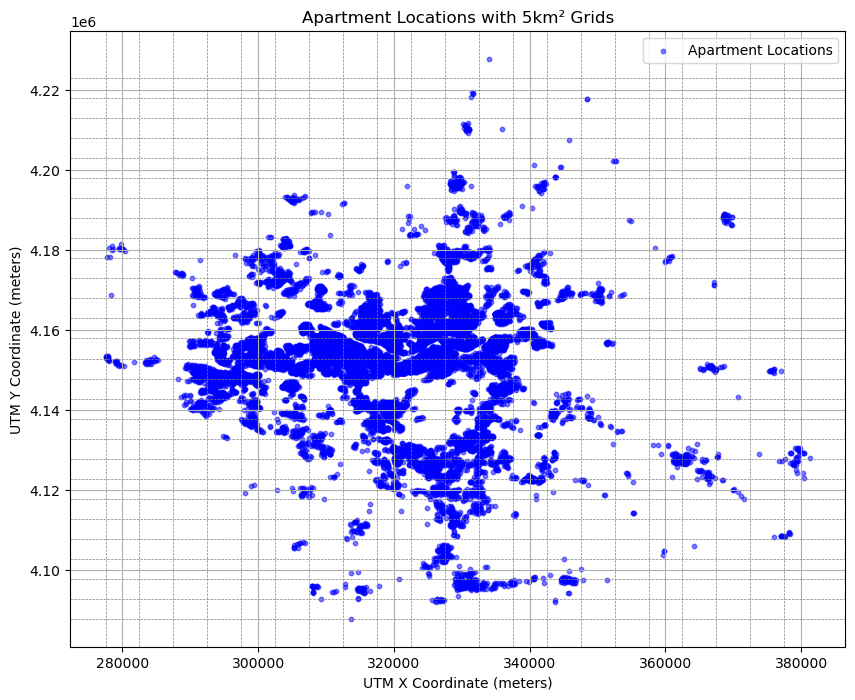

In [31]:
# 아파트 위치를 산점도로 그리기
plt.figure(figsize=(10, 8))
plt.scatter(location_df['utm_x'], location_df['utm_y'], c='blue', s=10, label='Apartment Locations', alpha=0.5)

# 격자 그리기 (5km 간격의 선을 그립니다)
min_x, max_x = location_df['utm_x'].min(), location_df['utm_x'].max()
min_y, max_y = location_df['utm_y'].min(), location_df['utm_y'].max()

# X축과 Y축에 5000미터 간격으로 선을 그림
for x in np.arange(min_x, max_x, 5000):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
for y in np.arange(min_y, max_y, 5000):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# 그래프 제목 및 레이블 설정
plt.title('Apartment Locations with 5km² Grids')
plt.xlabel('UTM X Coordinate (meters)')
plt.ylabel('UTM Y Coordinate (meters)')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\com\AppData\Local\Temp\ipykernel_2352\1663793217.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 253)  # 253개의 색상으로 설정


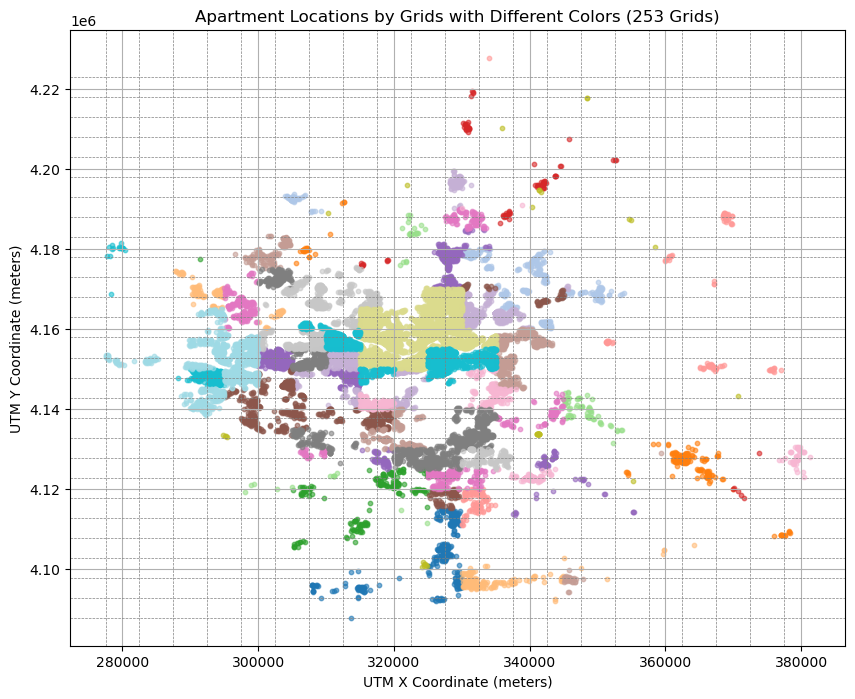

In [32]:
# 고유한 그리드마다 다른 색상을 적용하기 위해 고유 그리드를 인덱스로 설정
location_df['grid_id'] = location_df['grid_x'].astype(str) + '_' + location_df['grid_y'].astype(str)
unique_grids = location_df['grid_id'].unique()

# 각 그리드에 다른 색상을 할당 (253개의 색상을 가지는 cmap 사용)
colors = plt.cm.get_cmap('tab20', 253)  # 253개의 색상으로 설정

# 아파트 위치를 산점도로 그리고, 각 그리드에 맞는 색상 적용
plt.figure(figsize=(10, 8))
for i, grid_id in enumerate(unique_grids):
    grid_data = location_df[location_df['grid_id'] == grid_id]
    plt.scatter(grid_data['utm_x'], grid_data['utm_y'], color=colors(i), label=f"Grid {grid_id}", s=10, alpha=0.6)

# 격자 그리기 (5km 간격의 선을 그립니다)
min_x, max_x = location_df['utm_x'].min(), location_df['utm_x'].max()
min_y, max_y = location_df['utm_y'].min(), location_df['utm_y'].max()

# X축과 Y축에 5000미터 간격으로 선을 그림
for x in np.arange(min_x, max_x, 5000):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
for y in np.arange(min_y, max_y, 5000):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# 그래프 제목 및 레이블 설정
plt.title('Apartment Locations by Grids with Different Colors (253 Grids)')
plt.xlabel('UTM X Coordinate (meters)')
plt.ylabel('UTM Y Coordinate (meters)')
plt.grid(True)
plt.show()


In [ ]:
# pd.set_option('display.max_rows', None)

grid_apt_counts = location_df.groupby(['grid_x','grid_y']).size().reset_index(name='apartment_count')

grid_apt_counts.sort_values(['apartment_count'])

각 구역별로 나눠진걸 확인할 수 있었다.

이제 조금 더 상세한 비교를 위해 각 격자 구역별 전세가 추이를 확인해보겠다.

---

In [43]:
# 'apt_idx'를 기준으로 'deposit'의 평균을 구함
deposit_mean = df.groupby('apt_idx')['deposit'].mean().reset_index()

# 'apt_idx'를 기준으로 location_df와 병합하여 평균 deposit 값을 location_df에 추가
location_df = location_df.merge(deposit_mean, on='apt_idx', how='left')

# 'deposit_mean' 열을 'deposit'으로 이름 변경
location_df.rename(columns={'deposit': 'deposit_mean'}, inplace=True)


In [44]:
location_df.head()

,apt_idx,latitude,longitude,utm_x,utm_y,grid_x,grid_y,grid_id,deposit_mean
0,0,37.054314,127.045216,326185.513212,4.102685e+06,65,820,65_820,32823.103734
1,1,36.964647,127.055847,326927.596059,4.092717e+06,65,818,65_818,4750.000000
2,2,36.972390,127.084514,329497.144808,4.093524e+06,65,818,65_818,4818.181818
3,3,36.965423,127.048779,326300.076453,4.092816e+06,65,818,65_818,22361.570248
4,4,36.957089,127.047449,326162.673906,4.091893e+06,65,818,65_818,4658.333333


In [45]:
location_df['grid_id'] = (location_df['grid_x'].astype(str) + location_df['grid_y'].astype(str)).astype(int)

location_df.head()

,apt_idx,latitude,longitude,utm_x,utm_y,grid_x,grid_y,grid_id,deposit_mean
0,0,37.054314,127.045216,326185.513212,4.102685e+06,65,820,65820,32823.103734
1,1,36.964647,127.055847,326927.596059,4.092717e+06,65,818,65818,4750.000000
2,2,36.972390,127.084514,329497.144808,4.093524e+06,65,818,65818,4818.181818
3,3,36.965423,127.048779,326300.076453,4.092816e+06,65,818,65818,22361.570248
4,4,36.957089,127.047449,326162.673906,4.091893e+06,65,818,65818,4658.333333


In [55]:
grid_deposit_mean = location_df.groupby(['grid_id'])['deposit_mean'].mean().reset_index()

grid_deposit_mean

,grid_id,deposit_mean
0,55830,18876.882821
1,55833,5125.000000
2,55835,14950.056117
3,55836,8500.000000
4,56830,20280.267704
...,...,...
248,75826,15014.051163
249,75829,16079.507167
250,75830,14233.333333
251,76824,10592.521994


array([[<Axes: title={'center': 'deposit_mean'}>]], dtype=object)

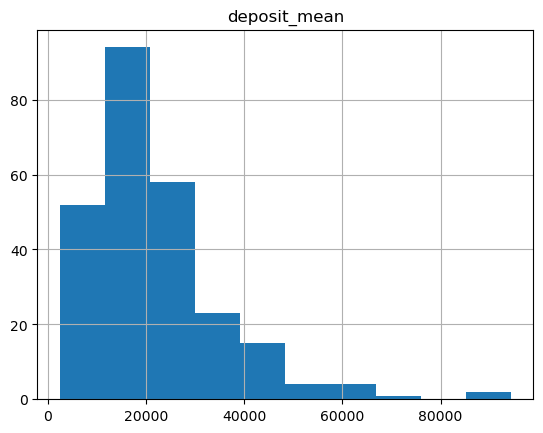

In [58]:
grid_deposit_mean.hist()

array([[<Axes: title={'center': 'deposit_mean'}>,
        <Axes: title={'center': 'log_deposit_mean'}>]], dtype=object)

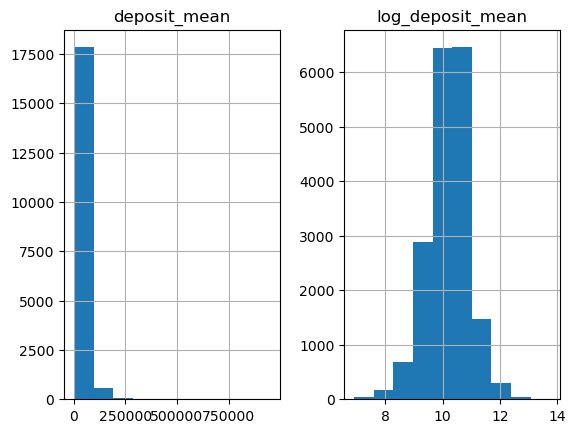

In [62]:
location_df['log_deposit_mean'] = np.log(location_df['deposit_mean'])
location_df[['deposit_mean','log_deposit_mean']].hist()

In [63]:
location_df.head()

,apt_idx,latitude,longitude,utm_x,utm_y,grid_x,grid_y,grid_id,deposit_mean,log_deposit_mean
0,0,37.054314,127.045216,326185.513212,4.102685e+06,65,820,65820,32823.103734,10.398888
1,1,36.964647,127.055847,326927.596059,4.092717e+06,65,818,65818,4750.000000,8.465900
2,2,36.972390,127.084514,329497.144808,4.093524e+06,65,818,65818,4818.181818,8.480152
3,3,36.965423,127.048779,326300.076453,4.092816e+06,65,818,65818,22361.570248,10.015099
4,4,36.957089,127.047449,326162.673906,4.091893e+06,65,818,65818,4658.333333,8.446413


In [64]:
# grid_x, grid_y 기준으로 deposit_mean의 평균을 계산
grid_deposit_mean = location_df.groupby(['grid_x', 'grid_y'])['deposit_mean'].mean().reset_index()

# location_df와 grid_deposit_mean을 병합하여 각 아파트의 좌표와 격자별 전세가 평균을 결합
merged_df = pd.merge(location_df, grid_deposit_mean, on=['grid_x', 'grid_y'], how='left', suffixes=('', '_grid_mean'))

array([[<Axes: title={'center': 'grid_mean'}>,
        <Axes: title={'center': 'log_grid_mean'}>]], dtype=object)

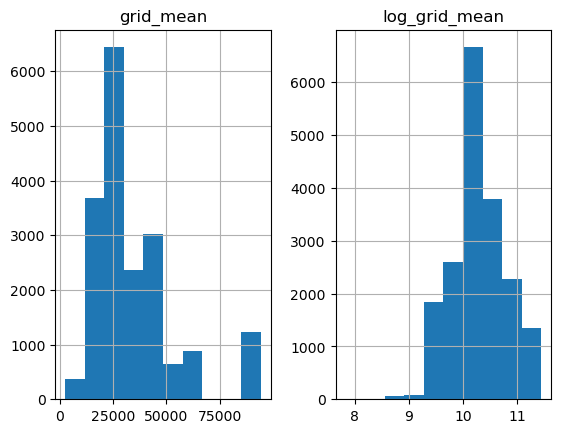

In [81]:
merged_df = merged_df.rename(columns={'deposit_mean_grid_mean': 'grid_mean'})
merged_df['log_grid_mean'] = np.log(merged_df['grid_mean'])
merged_df[['grid_mean','log_grid_mean']].hist()

In [75]:
merged_df

,apt_idx,latitude,longitude,utm_x,utm_y,grid_x,grid_y,grid_id,deposit_mean,log_deposit_mean,grid_mean,log_grid_mean
0,0,37.054314,127.045216,326185.513212,4.102685e+06,65,820,65820,32823.103734,10.398888,14932.327370,9.611284
1,1,36.964647,127.055847,326927.596059,4.092717e+06,65,818,65818,4750.000000,8.465900,10750.064922,9.282667
2,2,36.972390,127.084514,329497.144808,4.093524e+06,65,818,65818,4818.181818,8.480152,10750.064922,9.282667
3,3,36.965423,127.048779,326300.076453,4.092816e+06,65,818,65818,22361.570248,10.015099,10750.064922,9.282667
4,4,36.957089,127.047449,326162.673906,4.091893e+06,65,818,65818,4658.333333,8.446413,10750.064922,9.282667
...,...,...,...,...,...,...,...,...,...,...,...,...
18671,18671,37.540437,127.145738,336182.617601,4.156443e+06,67,831,67831,NaN,NaN,39515.060301,10.584437
18672,18672,37.499548,127.144838,336013.634073,4.151908e+06,67,830,67830,NaN,NaN,43062.817041,10.670415
18673,18673,37.463234,126.642899,291538.112869,4.148871e+06,58,829,58829,NaN,NaN,14351.160222,9.571586
18674,18674,37.459061,126.674991,294365.330414,4.148338e+06,58,829,58829,NaN,NaN,14351.160222,9.571586


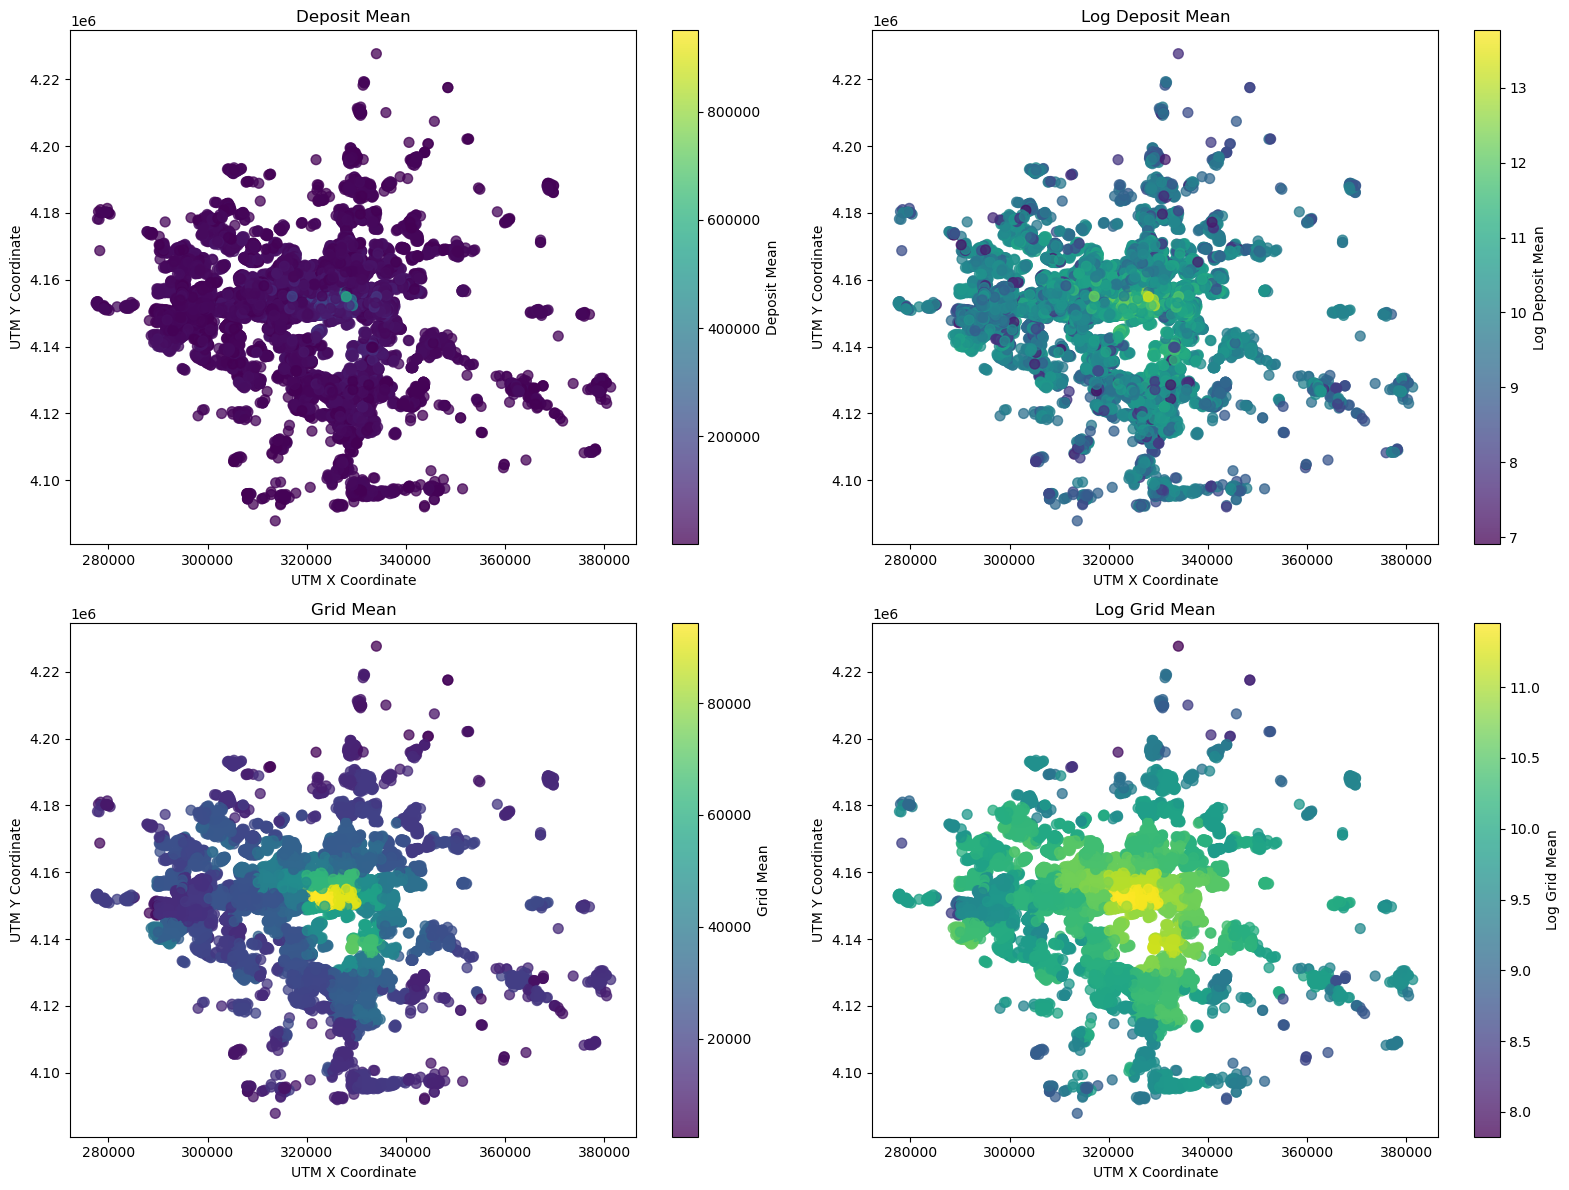

In [80]:
columns_to_plot = ['deposit_mean', 'log_deposit_mean', 'grid_mean', 'log_grid_mean']
titles = ['Deposit Mean', 'Log Deposit Mean', 'Grid Mean', 'Log Grid Mean']


fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i, col in enumerate(columns_to_plot):
    row, col_idx = divmod(i, 2)  # 2x2 그리드의 행과 열 계산
    scatter = axs[row, col_idx].scatter(merged_df['utm_x'], merged_df['utm_y'], 
                                        c=merged_df[col], cmap='viridis', s=50, alpha=0.75)
    axs[row, col_idx].set_title(titles[i])
    axs[row, col_idx].set_xlabel('UTM X Coordinate')
    axs[row, col_idx].set_ylabel('UTM Y Coordinate')
    fig.colorbar(scatter, ax=axs[row, col_idx], label=titles[i])

# 그래프 간의 레이아웃 조정
plt.tight_layout()
plt.show()

---

- Grid-based Methods 중 하나인 STING 알고리즘 기법을 사용해서 적용 시도

In [6]:
df.head()

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,_type,apt_idx,area,area_price,area_m2_price
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,train,0,25.8,658.914729,200.004471
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,train,0,25.8,891.472868,270.594284
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,train,0,25.8,891.472868,270.594284
3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,train,1,18.0,277.777778,84.260195
4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,train,2,18.1,99.447514,30.095302


In [13]:
grid_df = df[[
    'area_m2','contract_year_month','floor','built_year',
    'latitude','longitude','age','deposit','apt_idx']]

In [15]:
import matplotlib.pyplot as plt

C:\Users\com\AppData\Local\Temp\ipykernel_18260\1016298998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_df['grid_x'] = (grid_df['latitude'] // grid_size).astype(int)
C:\Users\com\AppData\Local\Temp\ipykernel_18260\1016298998.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_df['grid_y'] = (grid_df['longitude'] // grid_size).astype(int)


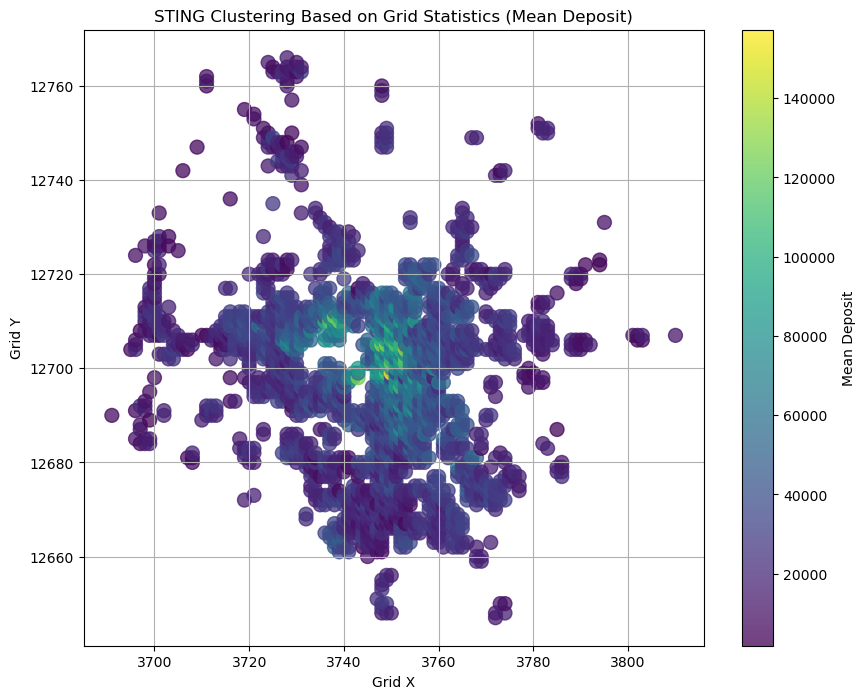

In [16]:
# 1. 격자 나누기: 위도와 경도를 일정 범위로 나누어 격자화
grid_size = 0.01  # 격자 크기 (1km ~ 1.5km 정도의 범위)
grid_df['grid_x'] = (grid_df['latitude'] // grid_size).astype(int)
grid_df['grid_y'] = (grid_df['longitude'] // grid_size).astype(int)

# 2. 각 격자의 통계 정보 계산 (평균, 표준편차 등)
grid_stats = grid_df.groupby(['grid_x', 'grid_y']).agg({
    'area_m2': ['mean','median', 'std'],
    'floor': ['mean','median', 'std'],
    # 'contract_year_month': ['mean','std'],
    'built_year': ['mean', 'median', 'std'],
    'age': ['mean','median', 'std'],
    'deposit': ['mean', 'median', 'std'],
    'latitude': ['count']  # 밀도를 나타내기 위해 각 격자의 데이터 포인트 수
}).reset_index()

# 열 이름 변경
grid_stats.columns = [
    'grid_x', 'grid_y', 
    'area_mean', 'area_median', 'area_std', 
    'floor_mean', 'floor_median', 'floor_std', 
    'built_mean', 'built_median', 'built_std', 
    'age_mean', 'age_median', 'age_std',
    'deposit_mean', 'deposit_median', 'deposit_std', 
    'count'
]

# 3. 밀도가 일정 이상인 격자를 클러스터로 묶음 (STING 방식으로 유사한 특성을 가진 격자 병합 가능)
# 여기서는 밀도(데이터 포인트 수)가 10 이상인 격자를 클러스터로 정의
cluster_threshold = 10
clusters = grid_stats[grid_stats['count'] >= cluster_threshold]

# 4. 결과 시각화 (격자별 평균 보증금에 따라 색상 표시)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(clusters['grid_x'], clusters['grid_y'], c=clusters['deposit_mean'], cmap='viridis', s=100, alpha=0.75)

# 컬러바 추가 (보증금 평균에 따른 색상 표시)
plt.colorbar(scatter, label='Mean Deposit')

# 그래프 설정
plt.title('STING Clustering Based on Grid Statistics (Mean Deposit)')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.grid(True)
plt.show()

In [18]:
clusters

,grid_x,grid_y,area_mean,area_median,area_std,floor_mean,floor_median,floor_std,built_mean,built_median,built_std,age_mean,age_median,age_std,deposit_mean,deposit_median,deposit_std,count
0,3691,12690,71.182000,78.0500,9.768008,6.800000,8.0,4.394802,1996.000000,1996.0,0.000000,25.666667,26.0,0.899735,7233.333333,7000.0,1334.523279,15
1,3695,12704,42.989456,39.6600,7.418148,3.705128,4.0,1.873319,1991.153846,1990.0,5.806572,30.102564,31.0,5.981768,5178.666667,4500.0,3007.706019,78
2,3696,12685,58.247056,55.2406,7.947118,7.126761,7.0,4.225533,2004.000000,2004.0,0.000000,17.746479,18.0,1.167639,10488.257576,10500.0,2281.873470,71
3,3696,12691,61.129024,59.6100,3.520361,4.243902,4.0,2.222392,1990.731707,1990.0,0.975305,30.731707,31.0,1.658680,5243.902439,5000.0,1727.722313,41
4,3696,12704,85.952119,84.9342,17.948060,7.289655,7.0,4.772487,2013.344828,2016.0,6.942601,7.827586,5.0,7.089061,20304.710145,20000.0,7561.465620,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,3802,12706,71.854821,72.9100,9.556477,3.035714,3.0,1.651052,1992.107143,1992.0,0.801784,28.785714,29.0,1.580728,4867.410714,4500.0,1479.779772,56
2075,3802,12707,62.102014,59.1000,15.771005,5.407143,4.0,3.665700,1999.585714,2002.0,6.760003,21.771429,21.0,6.763575,7826.923077,6650.0,4241.595218,140
2077,3803,12706,52.654783,58.6600,19.942848,6.391304,5.5,3.165637,2004.978261,2009.0,6.252072,16.239130,14.0,6.332227,7268.372093,8500.0,2883.844929,46
2078,3803,12707,79.701837,74.9800,14.660752,7.518519,8.0,4.065437,2013.827160,2020.0,10.847569,7.654321,2.0,10.770516,15986.333333,17000.0,4915.899627,81


----

grid 거리 조절 비교

In [65]:
location_df = df[['latitude','longitude','apt_idx']].groupby(['apt_idx']).mean()

In [66]:
location_df['utm_x'], location_df['utm_y']= zip(
    *location_df.apply(lambda row: latlon_to_utm(row['latitude'],row['longitude']), axis=1))

In [69]:
# 'apt_idx'를 기준으로 'deposit'의 평균을 구함
deposit_mean = df.groupby('apt_idx')['deposit'].mean().reset_index()

# 'apt_idx'를 기준으로 location_df와 병합하여 평균 deposit 값을 location_df에 추가
location_df = location_df.merge(deposit_mean, on='apt_idx', how='left')

In [70]:
location_df

,apt_idx,latitude,longitude,utm_x,utm_y,grid_x_3000,grid_y_3000,deposit
0,0,37.054314,127.045216,326185.513212,4.102685e+06,108,1367,32823.103734
1,1,36.964647,127.055847,326927.596059,4.092717e+06,108,1364,4750.000000
2,2,36.972390,127.084514,329497.144808,4.093524e+06,109,1364,4818.181818
3,3,36.965423,127.048779,326300.076453,4.092816e+06,108,1364,22361.570248
4,4,36.957089,127.047449,326162.673906,4.091893e+06,108,1363,4658.333333
...,...,...,...,...,...,...,...,...
18671,18671,37.540437,127.145738,336182.617601,4.156443e+06,112,1385,NaN
18672,18672,37.499548,127.144838,336013.634073,4.151908e+06,112,1383,NaN
18673,18673,37.463234,126.642899,291538.112869,4.148871e+06,97,1382,NaN
18674,18674,37.459061,126.674991,294365.330414,4.148338e+06,98,1382,NaN


In [74]:
# 고유한 grid_x_3000, grid_y_3000의 조합을 찾음
unique_grids_3000 = location_df[['grid_x_3000', 'grid_y_3000']].drop_duplicates()
unique_grids_5000 = location_df[['grid_x_5000', 'grid_y_5000']].drop_duplicates()

# 격자 개수 확인
num_grids_3000 = len(unique_grids_3000)
num_grids_5000 = len(unique_grids_5000)
print(f"3000m로 나눈 격자의 개수: {num_grids_3000}")
print(f"5000m로 나눈 격자의 개수: {num_grids_5000}")

3000m로 나눈 격자의 개수: 490
5000m로 나눈 격자의 개수: 253


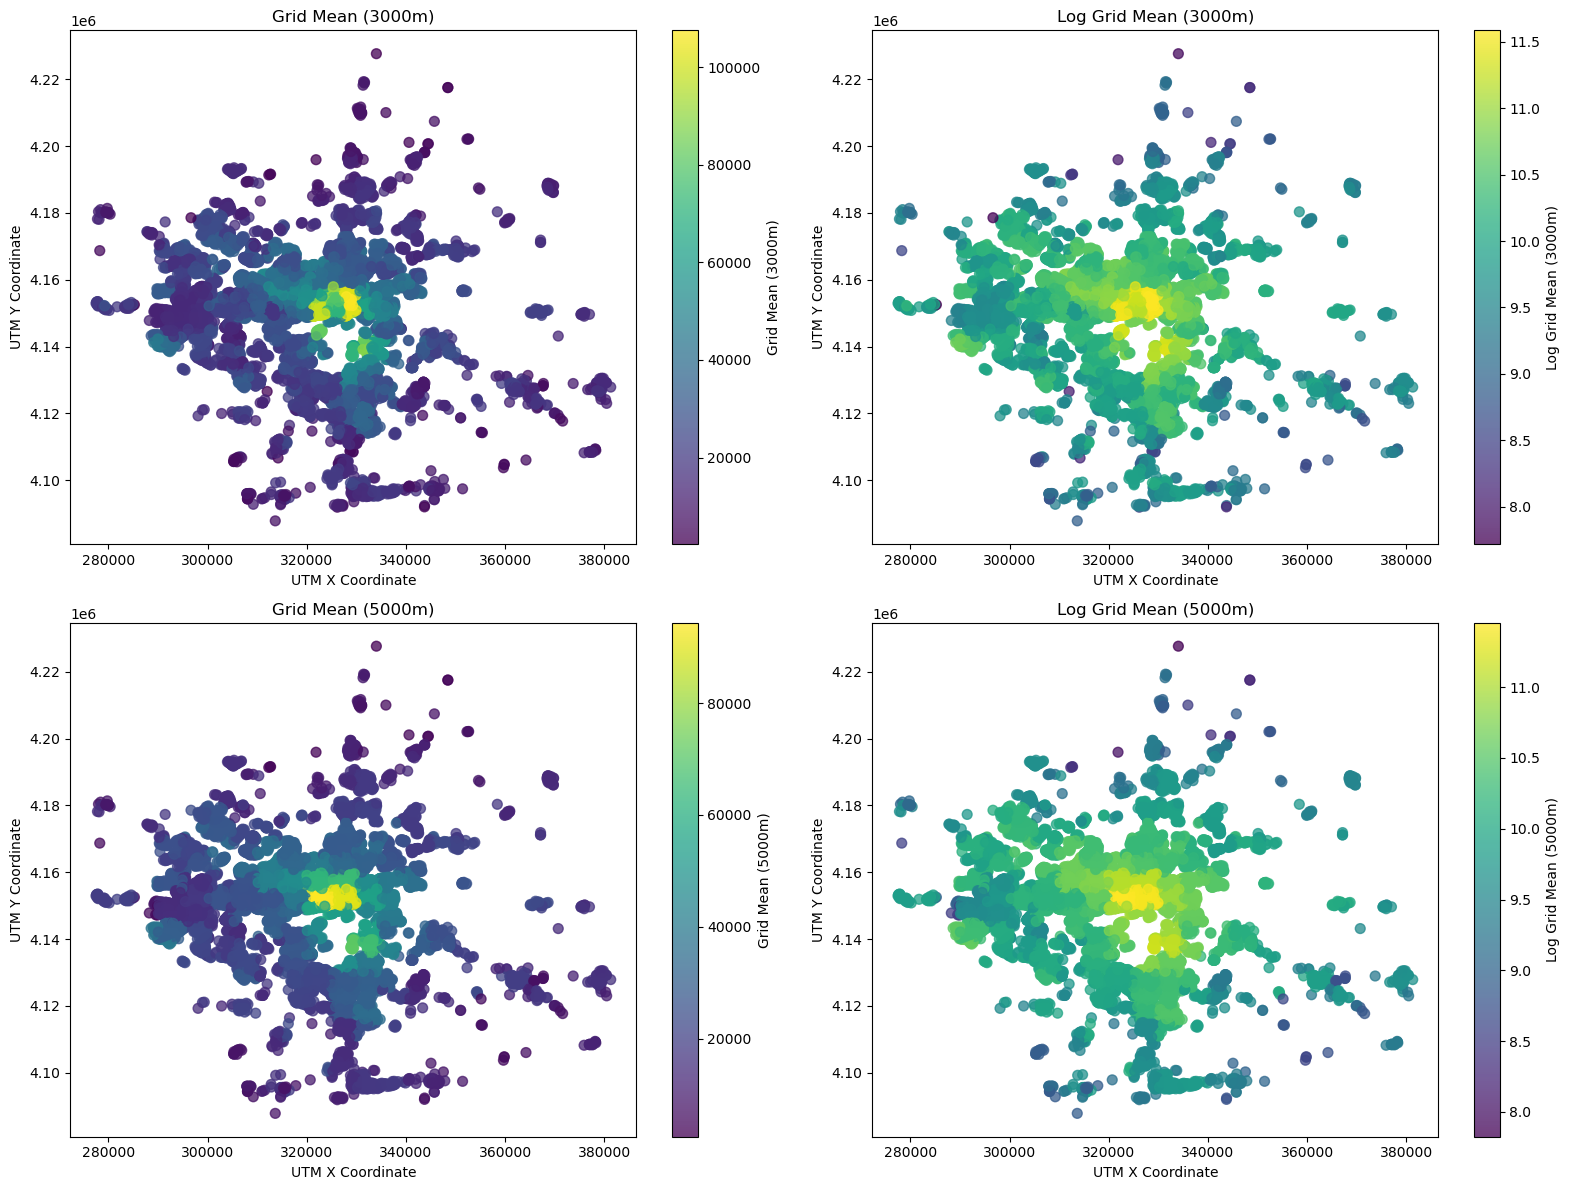

In [72]:
# 격자 크기 3000m로 계산
location_df['grid_x_3000'] = (location_df['utm_x'] // 3000).astype(int)
location_df['grid_y_3000'] = (location_df['utm_y'] // 3000).astype(int)

# grid_x_3000, grid_y_3000 기준으로 deposit_mean의 평균을 계산
grid_deposit_mean_3000 = location_df.groupby(['grid_x_3000', 'grid_y_3000'])['deposit'].mean().reset_index()

# 격자 크기 5000m로 계산
location_df['grid_x_5000'] = (location_df['utm_x'] // 5000).astype(int)
location_df['grid_y_5000'] = (location_df['utm_y'] // 5000).astype(int)

# grid_x_5000, grid_y_5000 기준으로 deposit_mean의 평균을 계산
grid_deposit_mean_5000 = location_df.groupby(['grid_x_5000', 'grid_y_5000'])['deposit'].mean().reset_index()

# location_df와 grid_deposit_mean_3000을 병합하여 격자별 평균 전세가를 추가
merged_df_3000 = pd.merge(location_df, grid_deposit_mean_3000, left_on=['grid_x_3000', 'grid_y_3000'],
                          right_on=['grid_x_3000', 'grid_y_3000'], how='left', suffixes=('', '_grid_mean_3000'))
merged_df_3000 = merged_df_3000.rename(columns={'deposit_grid_mean_3000': 'grid_mean_3000'})
merged_df_3000['log_grid_mean_3000'] = np.log(merged_df_3000['grid_mean_3000'])

# location_df와 grid_deposit_mean_5000을 병합하여 격자별 평균 전세가를 추가
merged_df_5000 = pd.merge(location_df, grid_deposit_mean_5000, left_on=['grid_x_5000', 'grid_y_5000'],
                          right_on=['grid_x_5000', 'grid_y_5000'], how='left', suffixes=('', '_grid_mean_5000'))
merged_df_5000 = merged_df_5000.rename(columns={'deposit_grid_mean_5000': 'grid_mean_5000'})
merged_df_5000['log_grid_mean_5000'] = np.log(merged_df_5000['grid_mean_5000'])

# 시각화할 컬럼
columns_to_plot_3000 = ['grid_mean_3000', 'log_grid_mean_3000']
columns_to_plot_5000 = ['grid_mean_5000', 'log_grid_mean_5000']
titles_3000 = ['Grid Mean (3000m)', 'Log Grid Mean (3000m)']
titles_5000 = ['Grid Mean (5000m)', 'Log Grid Mean (5000m)']

# 2x2 그리드로 서브플롯 생성 (격자 크기 3000m과 5000m 비교)
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 격자 3000m 시각화
for i, col in enumerate(columns_to_plot_3000):
    row, col_idx = divmod(i, 2)
    scatter = axs[row, col_idx].scatter(merged_df_3000['utm_x'], merged_df_3000['utm_y'],
                                        c=merged_df_3000[col], cmap='viridis', s=50, alpha=0.75)
    axs[row, col_idx].set_title(titles_3000[i])
    axs[row, col_idx].set_xlabel('UTM X Coordinate')
    axs[row, col_idx].set_ylabel('UTM Y Coordinate')
    fig.colorbar(scatter, ax=axs[row, col_idx], label=titles_3000[i])

# 격자 5000m 시각화
for i, col in enumerate(columns_to_plot_5000):
    row, col_idx = divmod(i, 2)
    scatter = axs[row+1, col_idx].scatter(merged_df_5000['utm_x'], merged_df_5000['utm_y'],
                                          c=merged_df_5000[col], cmap='viridis', s=50, alpha=0.75)
    axs[row+1, col_idx].set_title(titles_5000[i])
    axs[row+1, col_idx].set_xlabel('UTM X Coordinate')
    axs[row+1, col_idx].set_ylabel('UTM Y Coordinate')
    fig.colorbar(scatter, ax=axs[row+1, col_idx], label=titles_5000[i])

# 그래프 간 레이아웃 조정
plt.tight_layout()
plt.show()


----

함수 만든거 시험

In [5]:
from src.pre_process.deposit.grid_deposit import GridFeature

In [6]:
preprocessor = GridFeature(df)
pre_data = preprocessor.get_data()

In [7]:
pre_data.head()

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,_type,apt_idx,area,area_price,area_m2_price,grid_id
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,train,0,25.8,658.914729,200.004471,25481.802721
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,train,0,25.8,891.472868,270.594284,25481.802721
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,train,0,25.8,891.472868,270.594284,25481.802721
3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,train,1,18.0,277.777778,84.260195,18295.070423
4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,train,2,18.1,99.447514,30.095302,12549.134503
